In [24]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

In [25]:
##########################################################################
# Important Note: This notebook only uses one csv file to test the model #
##########################################################################

In [26]:
# Assign processed data to data_files
cwd = os.getcwd()
data_dir = os.path.join(cwd, "Data/")
data_files = [f for f in os.listdir(str(data_dir)) if f.endswith('csv')]

data_train_name = [f for f in data_files if 'TRAIN' in f]
data_test_name = [f for f in data_files if 'TEST' in f]

data_train = pd.read_csv(os.path.join(data_dir,data_train_name[0]))
data_test = pd.read_csv(os.path.join(data_dir,data_test_name[0]))


In [27]:
# Drop columns needed for classification group
boolean_col = ['highavse','lowavse','truedcr','lq']
data_train_filtered = data_train.drop(columns=boolean_col+['id'])
data_test_filtered = data_test.drop(columns=boolean_col+['id'])

# Find and Drop rows with missing values
data_train_filtered = data_train_filtered.dropna()
data_test_filtered = data_test_filtered.dropna()

# Drop irrelevant features and feature with perfect multicollinearity 
data_train_filtered = data_train_filtered.drop(columns=['tdrift50','tdrift10'])
data_test_filtered = data_test_filtered.drop(columns=['tdrift50','tdrift10'])

In [ ]:
# Train Test split
X_train = data_train_filtered.drop(columns=['energylabel'])
X_test = data_test_filtered.drop(columns=['energylabel'])
y_train = data_train_filtered['energylabel']
y_test = data_test_filtered['energylabel']

# Standardizing our columns
scaler = StandardScaler()
X_train_standardized = scaler.fit_transform(X_train)
X_test_standardized = scaler.transform(X_test)

# GridCV to find best lambda and using 5-fold cross-validation to ensure that our model can be generalizable to a foreign data set
alpha_range = np.logspace(-5, 2.5, 100)
param_grid = {"alpha": alpha_range}
ridge = Ridge()
grid_search = GridSearchCV(estimator=ridge, param_grid={"alpha": alpha_range}, cv=5, scoring='neg_mean_squared_error')

# Fit the model
grid_search.fit(X_train_standardized, y_train)

best_alpha = grid_search.best_params_['alpha']
print(f"lambda: {best_alpha}")

# Train the Ridge Regression model with the best alpha
ridge_reg = Ridge(alpha=best_alpha)
ridge_reg.fit(X_train_standardized,y_train)
y_pred = ridge_reg.predict(X_test_standardized)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2= r2_score(y_test, y_pred)

lambda: 1e-05


In [29]:
mse,r2

(4706.421982582284, 0.9894859088286434)

In [30]:
print(np.mean(abs(y_pred - y_test)))

16.143720399687858


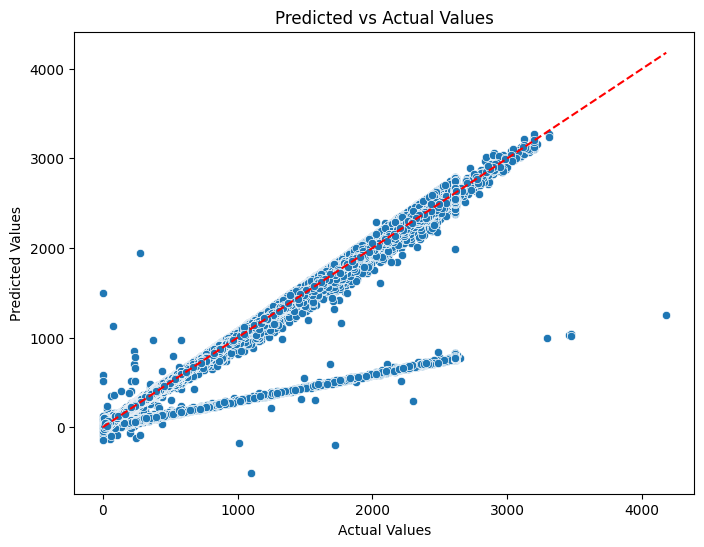

In [35]:
# Predicted vs Actual Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # 45-degree reference line
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Predicted vs Actual Values")
plt.show()

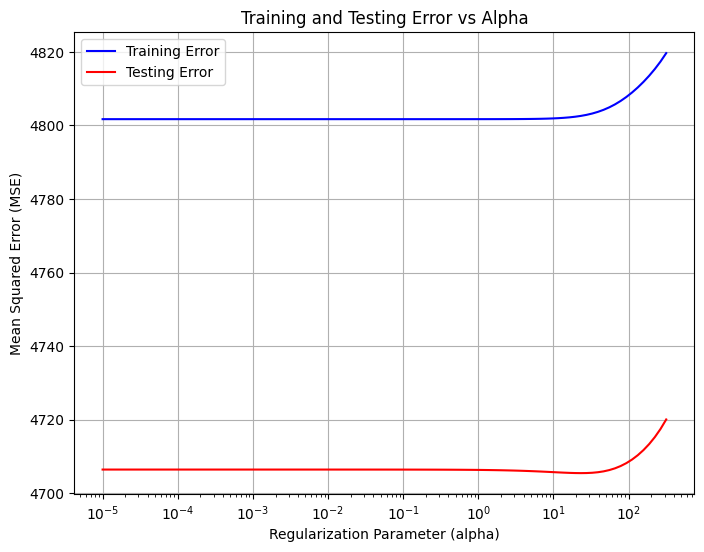

In [32]:
# Generate a range of alpha values
alpha_range = np.logspace(-5, 2.5, 100)

# Store MSE for training and testing
train_errors = []
test_errors = []

# Loop through each alpha to compute training and testing MSE
for alpha in alpha_range:
    # Train a Ridge regression model for each alpha
    ridge_reg = Ridge(alpha=alpha)
    ridge_reg.fit(X_train_standardized, y_train)

    # Predict on training and test data
    train_pred = ridge_reg.predict(X_train_standardized)
    test_pred = ridge_reg.predict(X_test_standardized)

    # Calculate MSE for training and testing
    train_mse = mean_squared_error(y_train, train_pred)
    test_mse = mean_squared_error(y_test, test_pred)

    # Append to the lists
    train_errors.append(train_mse)
    test_errors.append(test_mse)

# Plot training and testing error
plt.figure(figsize=(8, 6))
plt.semilogx(alpha_range, train_errors, label='Training Error', color='blue')
plt.semilogx(alpha_range, test_errors, label='Testing Error', color='red')
plt.xlabel('Regularization Parameter (alpha)')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Training and Testing Error vs Alpha')
plt.legend()
plt.grid(True)
plt.show()